In [17]:
# -*- coding: utf-8 -*-
"""
ECE 236A Project 1, MyClassifier.py template. Note that you should change the
name of this file to MyClassifier_{groupno}.py
"""
import pandas as pd
import numpy as np
import cvxpy as cp
import random
from random import choices


class MyClassifier:
    def __init__(self,K,M):
        self.K = K  #Number of classes
        self.M = M  #Number of features
        self.W = []
        self.w = []
        self.m_classifer_label = []
    def train(self, p, train_data, train_label):
        
        # THIS IS WHERE YOU SHOULD WRITE YOUR TRAINING FUNCTION
        #
        # The inputs to this function are:
        #
        # self: a reference to the classifier object.
        # train_data: a matrix of dimesions N_train x M, where N_train
        # is the number of inputs used for training. Each row is an
        # input vector.
        # trainLabel: a vector of length N_train. Each element is the
        # label for the corresponding input column vector in trainData.
        #
        # Make sure that your code sets the classifier parameters after
        # training. For example, your code should include a line that
        # looks like "self.W = a" and "self.w = b" for some variables "a"
        # and "b".
        #################################Start####################################
        
        #Check the train data and set the necessary parameter 
        #assert True==(train_data[0].all()!=[] and train_label!=None),"The train data or train label is None"
        self.M = len(train_data[0]) 

        #drop the data 
        train_data_copy=np.copy(train_data)
        self.__random_drop_data(p, train_data_copy)
        #extract the data for each class 
        classes_data_index = [] 
        classes_label = [] 
        for i, label in enumerate(train_label):
            if(label in classes_label):
                index = classes_label.index(label)
                classes_data_index[index].append(i)
            else:
                classes_label.append(label) 
                classes_data_index.append([i])

        self.K = len(classes_label)
        
        #Train the linear classifier for every possible combination of classes 
        #Output: 
        # CxM weight matrix, M = feature count, C = combination count 
        # self.m_classifer_label: classes labels in pair corrosponding to each linear classifier. Total C pairs
        total_classifier = int(self.K*(self.K-1)/2) 
        trained_classifier = 0 
        print("Training classifier: Total "+ str(total_classifier) + " classifiers")
        for i in range(0, len(classes_label)-1): 
            label_1 = classes_label[i]
            train_data_index_1 = classes_data_index[i]
            for j in range(i+1, len(classes_label)):
                label_2 = classes_label[j]
                train_data_index_2 = classes_data_index[j]
                print("Training" + str(label_1) + " "+ str(label_2)+" classifier")
               
                try:
                    W,w = self.__train_binary_classifier(train_data_copy,train_data_index_1, train_data_index_2)
                except:
                    print("Failed on "+ str(label_1)+" " + str(label_2) + "classifier, reattempting....")
                    W,w = self.__train_binary_classifier(train_data_copy,train_data_index_1, train_data_index_2)
                #append the data 
                self.W.append(W)
                self.w.append(w)
                self.m_classifer_label.append([label_1, label_2])
                trained_classifier += 1 
                self.__print_progressbar(total_classifier, trained_classifier)
        
    def f(self,input):
        # THIS IS WHERE YOU SHOULD WRITE YOUR CLASSIFICATION FUNCTION
        #
        # The inputs of this function are:
        #
        # input: the input to the function f(*), equal to g(y) = W^T y + w
        #
        # The outputs of this function are:
        #
        # s: this should be a scalar equal to the class estimated from
        # the corresponding input data point, equal to f(W^T y + w)
        # You should also check if the classifier is trained i.e. self.W and
        # self.w are nonempty
        #################################Start####################################
        #Output: predicted class number of the input
        assert True==( self.W!=[] and self.w!=None ), "self.W or self.w equal None!!!"
        #assert True==(len(self.W) == len(input)), "The input length doest not match the classifier!!!" 
        vote_counter = {}
        for i, combo in enumerate(self.m_classifer_label):
            label_1, label_2 = combo 
            weight = self.W[i]
            bias = self.w[i]
            assert True==(len(weight) == len(input)), "The size of the weight not match the input"
            if (weight.T@input + bias >=0):
                vote_counter[label_1] = vote_counter.get(label_1,0)+1
            else:
                 vote_counter[label_2] = vote_counter.get(label_2,0)+1

        s = max(vote_counter, key= vote_counter.get)
        return s 
      
        
    def classify(self,test_data):
        # THIS FUNCTION OUTPUTS ESTIMATED CLASSES FOR A DATA MATRIX
        # 
        # The inputs of this function are:
        # self: a reference to the classifier object.
        # test_data: a matrix of dimesions N_test x M, where N_test
        # is the number of inputs used for training. Each row is an
        # input vector.
        #
        #
        # The outputs of this function are:
        #
        # test_results: this should be a vector of length N_test,
        # containing the estimations of the classes of all the N_test
        # inputs.
        
        ##Check the dimension of of the input data 
        #assert True==(len(test_data)!=0 and test_data[0] != None)

        no_class = self.K  #Number of classes
        no_samp = test_data.shape[0]
        lList = self.m_classifer_label

        test_results = []
    
        for i in np.arange(no_samp):
            inp = test_data[i]
            test_results.append(self.f(inp))

        test_results = np.array(test_results)
        return test_results
        
    def TestCorrupted(self,p,test_data):
        # THIS FUNCTION OUTPUTS ESTIMATED CLASSES FOR A DATA MATRIX
        #
        #
        # The inputs of this function are:
        #
        # self: a reference to the classifier object.
        # test_data: a matrix of dimesions N_test x M, where N_test
        # is the number of inputs used for training. Each row is an
        # input vector.
        #
        # p:erasure probability
        #
        #
        # The outputs of this function are:
        #
        # test_results: this should be a vector of length N_test,
        # containing the estimations of the classes of all the N_test
        # inputs.
        
        test_data_copy = np.copy(test_data)
        for r in range(len(test_data_copy)):
          for c in range(len(test_data_copy[0])):
            test_data_copy[r][c] = test_data_copy[r][c] * choices([0, 1], weights=[p, 1-p], k=1)[0]
        
        return self.classify(test_data_copy)


    def __extract_two_digit(digit1,digit2,data,label):
        #OUTPUT:data only contan digit1, digit2, and corrosponding label 
        m_data = []
        m_label = []
        #Extrac the digit1 and digit 2 
        for i in range(0, len(label)):
            if label[i] == digit1:
                #print(Train_data[i,:])
                m_label.append(digit1)
                m_data.append(data[i])
            elif label[i]==digit2:
                m_label.append(digit2)
                m_data.append(data[i])

        return np.array(m_data), np.array(m_label)

    def __train_binary_classifier(self,train_data,train_data_1_index, train_data_2_index):
        a = cp.Variable(self.M)
        b = cp.Variable(1)
        #the size of z is the count of the set of train_data 
        #z = cp.Variable(len(train_label))
        z = cp.Variable(len(train_data_1_index) + len(train_data_2_index))
        #constrains
        constraints = [] 

        for i, index in enumerate(train_data_1_index):
            assert True == (len(train_data[index])==self.M), "The length of the train data set is not match the feature count"
            s = 1 
            constraints += [
                z[i]>=0,
                (1-s*(a.T@train_data[index]+b))<=z[i]
            ]

        for i, index in enumerate(train_data_2_index):
            assert True == (len(train_data[index])==self.M), "The length of the train data set is not match the feature count"
            s = -1 
            constraints += [
                z[i+len(train_data_1_index)]>=0,
                (1-s*(a.T@train_data[index]+b))<=z[i+len(train_data_1_index)]
            ]
        
        prob = cp.Problem(cp.Minimize(sum(z)),constraints)
        prob.solve() 
        
        return a.value, b.value
        #self.W  = a.value 
        #self.w = b.value

    def __random_drop_data(self, p, train_data):
        for i in range(len(train_data)):
            for j in range(len(train_data[0])):
                if(random.uniform(0,1)<p):
                    train_data[i][j] = 0 

    def __print_progressbar(self,total_task, cur_task):
        print(str(cur_task)+ "/"+ str(total_task))
        info = "["
        percent = cur_task/total_task 
        for i in range(0, int(60*percent)):
            info = info + "#"
        for i in range(int(60*percent), 60):
            info = info + "_"
        info = info + "]"
        print(info)


In [18]:
    from sklearn.metrics import confusion_matrix 
    import matplotlib.pyplot as plt
    Train_data = pd.read_csv("mnist_train.csv",header=0)
    Test_data = pd.read_csv("mnist_test.csv",header=0)
    Train_label = Train_data.iloc[:,0].values
    Test_label = Test_data.iloc[:,0].values
    Train_data = Train_data.iloc[:,1:].values
    Test_data = Test_data.iloc[:,1:].values
    classifier = MyClassifier(10,28*28)
    classifier.train(0.6,Train_data,Train_label)

Training classifier: Total 45 classifiers
Training5 0 classifier
1/45
[#___________________________________________________________]
Training5 4 classifier
2/45
[##__________________________________________________________]
Training5 1 classifier
3/45
[####________________________________________________________]
Training5 9 classifier
4/45
[#####_______________________________________________________]
Training5 2 classifier
5/45
[######______________________________________________________]
Training5 3 classifier
6/45
[########____________________________________________________]
Training5 6 classifier
7/45
[#########___________________________________________________]
Training5 7 classifier
8/45
[##########__________________________________________________]
Training5 8 classifier
9/45
[############________________________________________________]
Training0 4 classifier
10/45
[#############_______________________________________________]
Training0 1 classifier
11/45
[##############___

0.8508


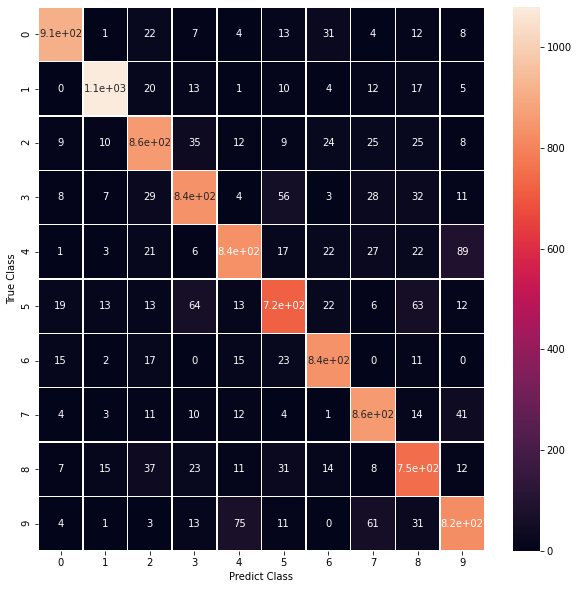

In [22]:
    import seaborn as sn
    import matplotlib.pyplot as plt
    subset = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
    test_pred = classifier.TestCorrupted(0.6, Test_data); 
    cm = confusion_matrix(test_pred, Test_label)
    df_cm = pd.DataFrame(cm, index = [i for i in subset],
                  columns = [i for i in subset])
    fig, ax = plt.subplots(figsize=(10,10))    
    #mat = sns.load_dataset(df_cm)
    #mat.pivot("Predict Class", "True Class")
    sn.heatmap(df_cm, annot=True,linewidths=.5, ax = ax)
    plt.ylabel("True Class")
    plt.xlabel("Predict Class")
    acc_test_corr = np.mean(test_pred==Test_label)
    print(acc_test_corr)

<AxesSubplot:>